# Imports

In [182]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import re
import time
from sklearn.impute import KNNImputer

start_time = time.time()


chunksize = 10 ** 3  # Chunksize de 1000 lignes
filename = 'products.csv'
nan_rates = []

try:
    reader = pd.read_csv(filename, chunksize=chunksize, sep='\t')

    for chunk in reader:
        nan_rates.append(chunk.isna().mean(axis=0))

except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

# Calcul des taux moyens de remplissage des chunks
if nan_rates:
    inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)
    cols_to_load = inds_nan_rate[inds_nan_rate < 0.7].index.tolist()

    # Chargement des données filtrées
    df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)
    df = df.drop(['url','states','additives_n','nutrition-score-fr_100g','energy_100g','main_category','completeness','nutrient_levels_tags','brands','nova_group','food_groups','categories','creator','serving_size','serving_quantity','categories','image_nutrition_url','ingredients_analysis_tags','ingredients_tags','ingredients_text','image_nutrition_small_url','created_datetime','food_groups_tags','food_groups_en','states_tags','sodium_100g','states_en','last_image_datetime','last_modified_t','last_modified_datetime','created_t','last_modified_by','main_category_en','image_url','image_small_url','last_updated_t','last_image_t','brands_tags','last_updated_datetime','categories_en','categories_tags','countries_tags','countries_en'], axis=1)
    print(df.head())
    
# Liste des mots clés à rechercher dans la colonne 'countries'
keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']

# Remplacer les valeurs NaN par une chaîne vide pour éviter les erreurs de filtrage
df['countries'].fillna('', inplace=True)

# Filtrer les lignes où 'countries' ne contient pas les mots clés spécifiés
mask = df['countries'].str.contains('|'.join(keywords), case=False, na=False)
df = df[mask]

ParserError: Error tokenizing data. C error: Expected 206 fields in line 1537879, saw 234



/var/folders/25/t6v1433n06x6vfl9wjbxn8sw0000gn/T/ipykernel_12411/2391523809.py:33: DtypeWarning: Columns (0,50,52,56,58,88,89,91,92) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filename, sep='\t', usecols=cols_to_load)


                     code      product_name  countries nutriscore_score  \
0       00000000000000225    jeunes pousses  en:france              NaN   
1  0000000000000207025004             Andrè      en:de              NaN   
2    00000000000003429145           L.casei      Spain              NaN   
3    00000000000026772226              Skyr     France             -5.0   
4           0000000000017  Vitória crackers     France              NaN   

  nutriscore_grade            pnns_groups_1   pnns_groups_2 ecoscore_grade  \
0          unknown    Fruits and vegetables      Vegetables              b   
1          unknown                  unknown         unknown        unknown   
2          unknown                  unknown         unknown        unknown   
3                a  Milk and dairy products  Dairy desserts              b   
4          unknown                  unknown         unknown        unknown   

  energy-kcal_100g fat_100g saturated-fat_100g  carbohydrates_100g  \
0         

# Information Dataframe

In [184]:
df.info

<bound method DataFrame.info of                          code                  product_name        countries  \
0           00000000000000225                jeunes pousses        en:france   
3        00000000000026772226                          Skyr           France   
4               0000000000017              Vitória crackers           France   
5               0000000000031                         Cacao           France   
11              0000000000100   moutarde au moût de raisin            France   
...                       ...                           ...              ...   
3307643              99999995                Steak haché 5%           France   
3307647         9999999905667                           NaN  en:South Africa   
3307649         9999999916298       Beurre de cacahuète bio            en:fr   
3307652             999999999       Thé noir BIO Darjeeling        en:france   
3307657         9999999999994     Light & Free SKYR A BOIRE        en:france   

       

In [185]:
df.head(5)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,Fruits and vegetables,Vegetables,b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00000000000026772226,Skyr,France,-5.0,a,Milk and dairy products,Dairy desserts,b,57.0,0.2,0.1,3.9,3.9,NaN,10.0,0.09,NaN
4,0000000000017,Vitória crackers,France,NaN,unknown,unknown,unknown,unknown,375.0,7.0,3.08,70.1,15.0,NaN,7.8,1.40,NaN
5,0000000000031,Cacao,France,NaN,unknown,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,0000000000100,moutarde au moût de raisin,France,18.0,d,Fat and sauces,Dressings and sauces,c,NaN,8.2,2.2,29.0,22.0,0.0,5.1,4.60,0.0


In [186]:
df.dtypes

code                                                      object
product_name                                              object
countries                                                 object
nutriscore_score                                          object
nutriscore_grade                                          object
pnns_groups_1                                             object
pnns_groups_2                                             object
ecoscore_grade                                            object
energy-kcal_100g                                          object
fat_100g                                                  object
saturated-fat_100g                                        object
carbohydrates_100g                                       float64
sugars_100g                                              float64
fiber_100g                                               float64
proteins_100g                                            float64
salt_100g                

# Fonction Nettoyage Données

In [188]:
def clean_and_impute_data(df):
    
    def detect_and_remove_cyrillic(df, column):
        cyrillic_pattern = re.compile(r'[\u0400-\u04FF]+')
        cyrillic_indices = df[df[column].apply(lambda x: bool(cyrillic_pattern.search(str(x))))].index
        df.drop(cyrillic_indices, inplace=True)
        df.reset_index(drop=True, inplace=True)
        print(f"\nNombre de lignes supprimées : {len(cyrillic_indices)}")
        print("Étape de suppression des caractères cyrilliques complétée.")
    
    def redistribute_nutrient_values(row, columns_to_check, max_sum=100):
        total = row[columns_to_check].sum()
        if total > max_sum:
            factor = max_sum / total
            row[columns_to_check] *= factor
        return row
    
    def check_nutrient_sum(df):
        columns_to_check = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
                            'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']
        nutrient_sum = df[columns_to_check].sum(axis=1)
        rows_with_high_sum = df[nutrient_sum > 100].copy()
        
        for idx, row in rows_with_high_sum.iterrows():
            df.loc[idx, columns_to_check] = redistribute_nutrient_values(row, columns_to_check)
        
        count_high_sum = rows_with_high_sum.shape[0]
        
        if count_high_sum > 0:
            print(f"\nNombre de lignes avec une somme strictement supérieure à 100 : {count_high_sum}")
        else:
            print("Aucune ligne avec une somme des colonnes strictement supérieure à 100 trouvée.")
        
        return count_high_sum
    
    # Suppression cyrillique
    detect_and_remove_cyrillic(df, 'product_name')
    
    # Focalisation sur le marché français
    keywords = ['France', 'French', 'Francia', 'Frankreich', 'Polynésie française', 'FR', 'fr']
    df['countries'].fillna('', inplace=True)
    df = df[df['countries'].str.contains('|'.join(keywords), case=False, na=False)]
    print("Étape de focalisation sur le marché français complétée.")
    
    # Suppression des doublons basés sur le code
    df.drop_duplicates(subset='code', inplace=True)
    print("Étape de suppression des doublons basée sur le code complétée.")

    # Suppression des lignes avec des valeurs NaN dans 'product_name'
    nombre_lignes_avant = df.shape[0]
    df.dropna(subset=['product_name'], inplace=True)
    nombre_lignes_apres = df.shape[0]
    nombre_lignes_supprimees = nombre_lignes_avant - nombre_lignes_apres
    print(f"\nNombre de lignes supprimées: {nombre_lignes_supprimees}")
    print("Étape de suppression des lignes avec des NaN dans 'product_name' complétée.")
    
    # Remplacement des valeurs >100 par la moyenne en fonction du 'product_name'
    columns_to_check = [
        'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 
        'fruits-vegetables-nuts-estimate-from-ingredients_100g'
    ]
    
    df[columns_to_check] = df[columns_to_check].apply(pd.to_numeric, errors='coerce')
    means = df.groupby('product_name')[columns_to_check].transform('mean')
    
    for column in columns_to_check:
        df[column] = np.where(df[column] > 100, means[column], df[column])
    
    values_above_100 = df[columns_to_check] > 100
    count_above_100 = values_above_100.sum().sum()
    print(f"Nombre de valeurs supérieures à 100 après correction : {count_above_100}")
    
    df.drop(index=df[values_above_100.any(axis=1)].index, inplace=True)
    print("Étape de remplacement des valeurs >100 par la moyenne complétée.")
    
    # Imputation itérative des NaN
    imputer = IterativeImputer(max_iter=50, tol=0.001, sample_posterior=True, random_state=0)
    df_imputed = imputer.fit_transform(df[columns_to_check])
    
    for col in columns_to_check:
        df[col] = df_imputed[:, columns_to_check.index(col)]
    
    df[columns_to_check] = df[columns_to_check].clip(0, 900).round(2)
    
    print("Étape d'imputation itérative des NaN complétée.")
    
    # Suppression des lignes avec des NaN dans 'product_name'
    nombre_lignes_avant = df.shape[0]
    df.dropna(subset=['product_name'], inplace=True)
    nombre_lignes_apres = df.shape[0]
    nombre_lignes_supprimees = nombre_lignes_avant - nombre_lignes_apres
    print(f"\nNombre de lignes supprimées: {nombre_lignes_supprimees}")
    print("Étape de suppression des lignes avec des NaN dans 'product_name' complétée.")
    
    # Suppression des lignes avec des valeurs négatives dans les colonnes spécifiées
    negative_values = {}
    for column in columns_to_check:
        count_negatives = df[df[column] < 0].shape[0]
        if count_negatives > 0:
            negative_values[column] = count_negatives
            df = df[df[column] >= 0]
    
    print("\nRésumé des lignes supprimées contenant des valeurs négatives :")
    for column, count in negative_values.items():
        print(f"Colonne '{column}': {count} lignes supprimées contenant des valeurs négatives")
    print("Étape de suppression des lignes avec des valeurs négatives complétée.")
    
    # Suppression des lignes où 'energy-kcal_100g' est supérieur à 900
    df['energy-kcal_100g'] = pd.to_numeric(df['energy-kcal_100g'], errors='coerce')
    high_energy_rows = df[df['energy-kcal_100g'] > 900]
    count_high_energy = high_energy_rows.shape[0]
    print(f"Nombre de lignes où 'energy-kcal_100g' est supérieur à 900 : {count_high_energy}")
    
    df.drop(index=high_energy_rows.index, inplace=True)
    
    print("Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.")
    
    # Redistribution des valeurs si la somme des colonnes dépasse 100
    modified_counter = 0
    modified_counter += check_nutrient_sum(df)
    
    print(f"\nNombre de valeurs modifiées pendant la redistribution : {modified_counter}")
    print("Étape de redistribution des valeurs complétée.")
    
    # Conversion de nutriscore_score en numérique
    df['nutriscore_score'] = pd.to_numeric(df['nutriscore_score'], errors='coerce')
    
    # Imputation des NaN dans 'nutriscore_score' par la médiane en fonction de 'product_name'
    initial_nan_count_nutriscore = df['nutriscore_score'].isna().sum()
    df['nutriscore_score'] = df.groupby('product_name')['nutriscore_score'].transform(lambda x: x.fillna(x.median()))
    final_nan_count_nutriscore = df['nutriscore_score'].isna().sum()
    modified_nutriscore_count = initial_nan_count_nutriscore - final_nan_count_nutriscore
    
    print(f"Nombre de valeurs modifiées (nutriscore_score) : {modified_nutriscore_count}")

    # Imputation itérative en utilisant d'autres colonnes pour guider l'imputation
    imputer = IterativeImputer(max_iter=100, random_state=10, min_value=0, max_value=900)
    columns_to_impute = ['energy-kcal_100g', 'fat_100g', 'sugars_100g','saturated-fat_100g','carbohydrates_100g','fiber_100g','proteins_100g','salt_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g']  # Colonnes à imputer
    df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

    # Arrondir les valeurs imputées à deux chiffres après la virgule
    df = df.round(2)
    print("Étape de Iterative Imputer terminée")

    return df

In [189]:
df = clean_and_impute_data(df)


Nombre de lignes supprimées : 424
Étape de suppression des caractères cyrilliques complétée.
Étape de focalisation sur le marché français complétée.
Étape de suppression des doublons basée sur le code complétée.

Nombre de lignes supprimées: 34975
Étape de suppression des lignes avec des NaN dans 'product_name' complétée.
Nombre de valeurs supérieures à 100 après correction : 1290
Étape de remplacement des valeurs >100 par la moyenne complétée.
Étape d'imputation itérative des NaN complétée.

Nombre de lignes supprimées: 0
Étape de suppression des lignes avec des NaN dans 'product_name' complétée.

Résumé des lignes supprimées contenant des valeurs négatives :
Étape de suppression des lignes avec des valeurs négatives complétée.
Nombre de lignes où 'energy-kcal_100g' est supérieur à 900 : 981
Étape de suppression des lignes où 'energy-kcal_100g' est supérieur à 900 complétée.

Nombre de lignes avec une somme strictement supérieure à 100 : 324948

Nombre de valeurs modifiées pendant la

# Fin Test

In [191]:
df.isna().mean()

code                                                     0.000000
product_name                                             0.000000
countries                                                0.000000
nutriscore_score                                         0.445141
nutriscore_grade                                         0.007741
pnns_groups_1                                            0.000002
pnns_groups_2                                            0.000000
ecoscore_grade                                           0.000135
energy-kcal_100g                                         0.000000
fat_100g                                                 0.000000
saturated-fat_100g                                       0.000000
carbohydrates_100g                                       0.000000
sugars_100g                                              0.000000
fiber_100g                                               0.000000
proteins_100g                                            0.000000
salt_100g 

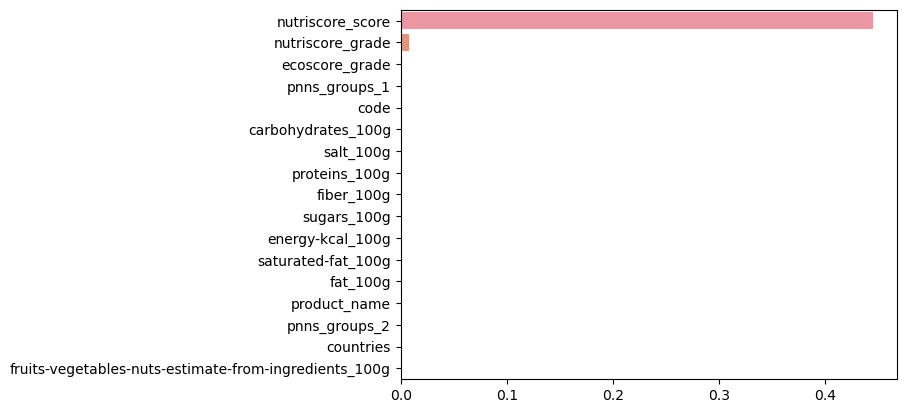

In [192]:
valeurs_manq = df.isna().mean().sort_values(ascending=False)
sns.barplot(x=valeurs_manq.values, y=valeurs_manq.index);

## Test fin

In [194]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

Pourcentage des valeurs égales à 0 :
code                                                      0.000000
product_name                                              0.000000
countries                                                 0.000000
nutriscore_score                                          2.704208
nutriscore_grade                                          0.000000
pnns_groups_1                                             0.000000
pnns_groups_2                                             0.000000
ecoscore_grade                                            0.000000
energy-kcal_100g                                          1.776774
fat_100g                                                 12.885998
saturated-fat_100g                                       17.824391
carbohydrates_100g                                        9.102048
sugars_100g                                              15.073326
fiber_100g                                               28.303426
proteins_100g            

In [195]:
df.head(10)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,Fruits and vegetables,Vegetables,b,65.96,0.98,0.00,2.36,0.00,9.74,14.86,0.00,60.91
1,00000000000026772226,Skyr,France,-5.0,a,Milk and dairy products,Dairy desserts,b,57.00,0.20,0.10,3.90,3.90,0.00,10.00,0.09,16.68
2,0000000000017,Vitória crackers,France,NaN,unknown,unknown,unknown,unknown,375.00,6.38,2.81,63.91,13.68,4.83,7.11,1.28,6.93
3,0000000000031,Cacao,France,22.0,unknown,unknown,unknown,unknown,534.18,34.06,6.94,43.17,0.00,5.95,7.88,1.99,0.00
4,0000000000100,moutarde au moût de raisin,France,18.0,d,Fat and sauces,Dressings and sauces,c,267.93,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00
5,0000000000123,Sauce Sweety chili 0%,France,NaN,unknown,unknown,unknown,unknown,21.00,0.00,0.00,4.80,0.40,0.00,0.20,2.04,0.00
6,0000000000178,Mini coco,France,NaN,unknown,unknown,unknown,unknown,60.00,3.00,1.00,10.00,3.00,0.00,2.00,1.15,5.57
7,0000000000208,Pistou d'ail des ours,France,NaN,unknown,unknown,unknown,unknown,232.09,0.00,0.00,36.11,17.01,7.27,11.92,1.16,16.94
8,000000000025,Thé noir glacé pomme,en:fr,NaN,unknown,unknown,unknown,unknown,52.00,0.50,0.10,12.00,11.00,4.80,0.50,0.00,56.35
9,0000000000284,Pain maïs,en:france,8.5,unknown,unknown,unknown,unknown,363.63,3.65,0.00,52.56,29.22,0.00,14.46,0.11,38.41


# Visualisation

## Matrices de corrélation

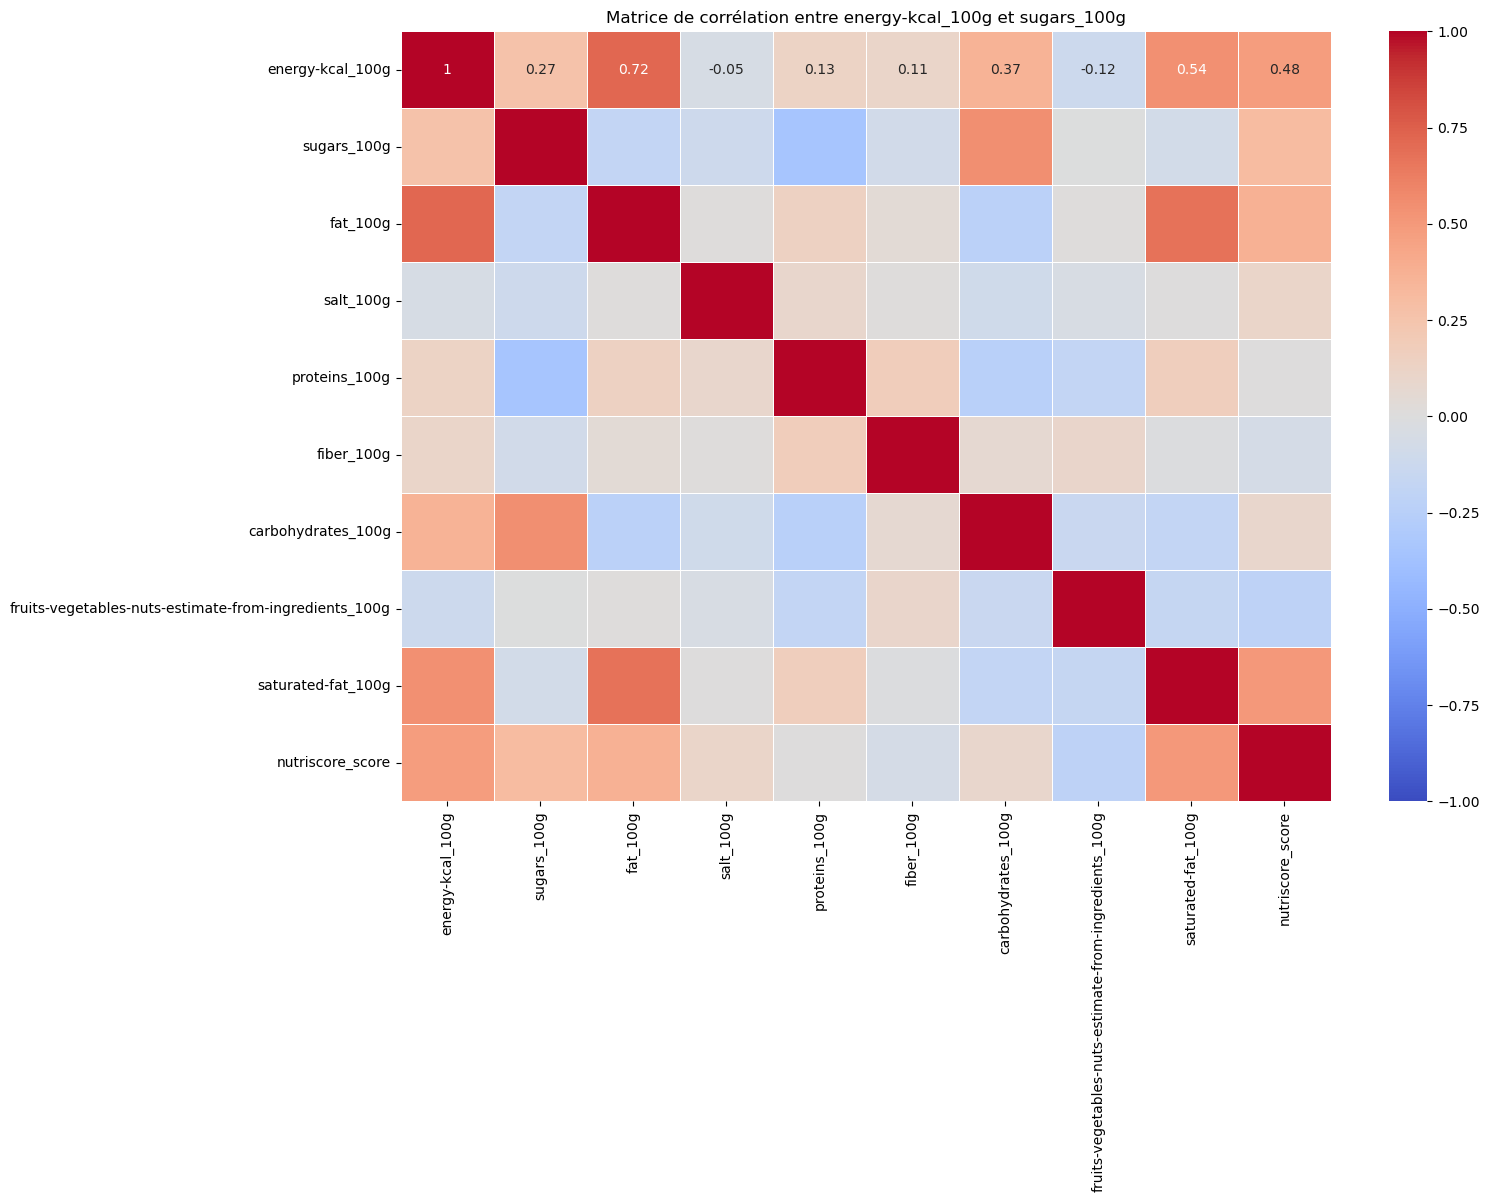

In [198]:
correlation_matrix = df[['energy-kcal_100g', 'sugars_100g','fat_100g','salt_100g','proteins_100g','fiber_100g','carbohydrates_100g','fruits-vegetables-nuts-estimate-from-ingredients_100g','saturated-fat_100g','nutriscore_score',]].corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, linewidths=.5)
plt.title('Matrice de corrélation entre energy-kcal_100g et sugars_100g')
plt.show()

## Histogramme Energy/100gr

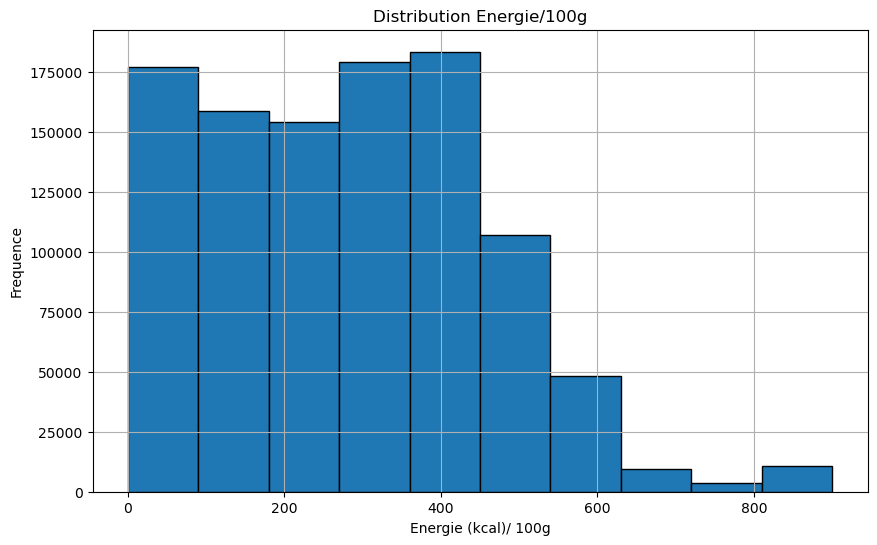

In [200]:
plt.figure(figsize=(10, 6))
plt.hist(df['energy-kcal_100g'], edgecolor='black')
plt.xlabel('Energie (kcal)/ 100g')
plt.ylabel('Frequence')
plt.title('Distribution Energie/100g')
plt.grid(True)
plt.show()

# Histogramme sucres/100g

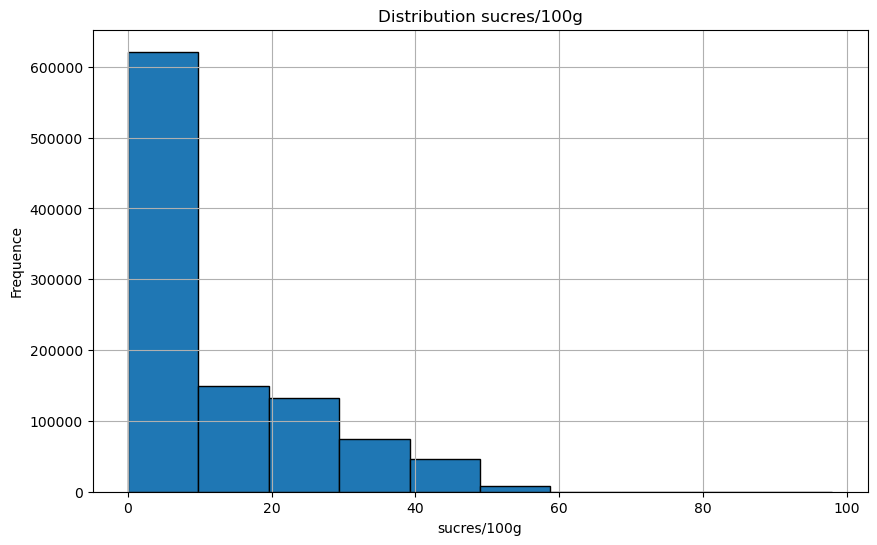

In [202]:
plt.figure(figsize=(10, 6))
plt.hist(df['sugars_100g'], edgecolor='black')
plt.xlabel('sucres/100g')
plt.ylabel('Frequence')
plt.title('Distribution sucres/100g')
plt.grid(True)
plt.show()

# Répartition des produits par nutriscore

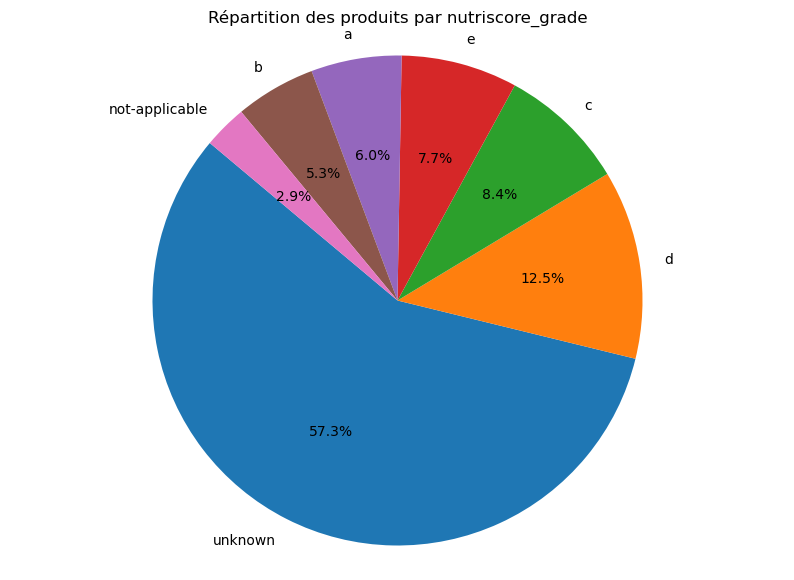

In [204]:
score_counts = df['nutriscore_grade'].value_counts()

# Créer le graphique camembert
plt.figure(figsize=(10, 7))
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des produits par nutriscore_grade')
plt.axis('equal')  # Assure que le camembert est un cercle
plt.show()

# countplot répartition des produits par pnns_groups_1

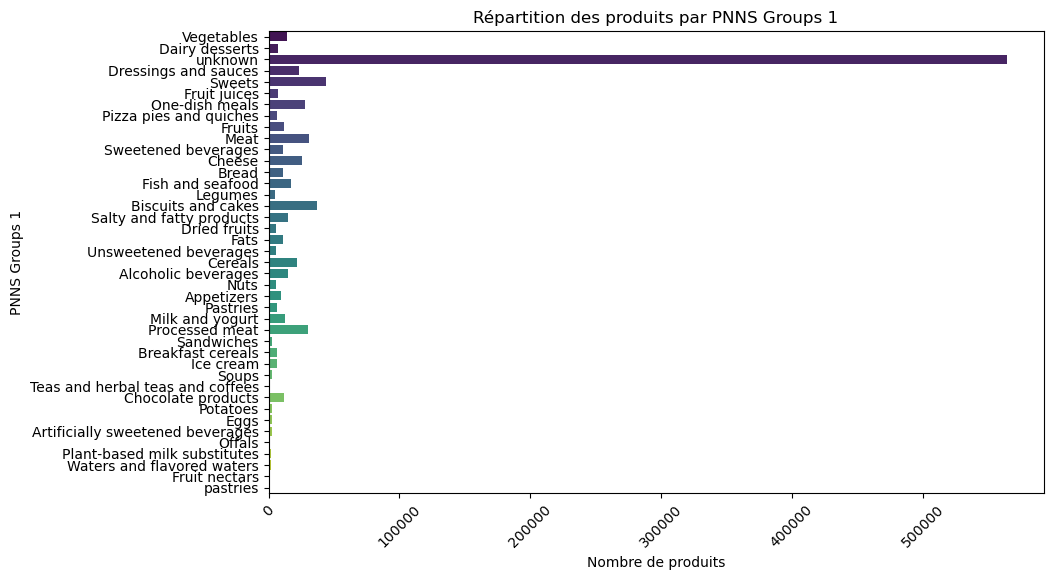

In [205]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='pnns_groups_2', palette='viridis')
plt.title('Répartition des produits par PNNS Groups 1')
plt.ylabel('PNNS Groups 1')
plt.xlabel('Nombre de produits')
plt.xticks(rotation=45)
plt.show()

# Timer

In [207]:
end_time = time.time()
execution_time = end_time - start_time

print(f"Temps d'exécution total du notebook : {execution_time:.4f} secondes")

Temps d'exécution total du notebook : 921.7058 secondes


In [208]:
df.head(10)

,code,product_name,countries,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,ecoscore_grade,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g
0,00000000000000225,jeunes pousses,en:france,NaN,unknown,Fruits and vegetables,Vegetables,b,65.96,0.98,0.00,2.36,0.00,9.74,14.86,0.00,60.91
1,00000000000026772226,Skyr,France,-5.0,a,Milk and dairy products,Dairy desserts,b,57.00,0.20,0.10,3.90,3.90,0.00,10.00,0.09,16.68
2,0000000000017,Vitória crackers,France,NaN,unknown,unknown,unknown,unknown,375.00,6.38,2.81,63.91,13.68,4.83,7.11,1.28,6.93
3,0000000000031,Cacao,France,22.0,unknown,unknown,unknown,unknown,534.18,34.06,6.94,43.17,0.00,5.95,7.88,1.99,0.00
4,0000000000100,moutarde au moût de raisin,France,18.0,d,Fat and sauces,Dressings and sauces,c,267.93,8.20,2.20,29.00,22.00,0.00,5.10,4.60,0.00
5,0000000000123,Sauce Sweety chili 0%,France,NaN,unknown,unknown,unknown,unknown,21.00,0.00,0.00,4.80,0.40,0.00,0.20,2.04,0.00
6,0000000000178,Mini coco,France,NaN,unknown,unknown,unknown,unknown,60.00,3.00,1.00,10.00,3.00,0.00,2.00,1.15,5.57
7,0000000000208,Pistou d'ail des ours,France,NaN,unknown,unknown,unknown,unknown,232.09,0.00,0.00,36.11,17.01,7.27,11.92,1.16,16.94
8,000000000025,Thé noir glacé pomme,en:fr,NaN,unknown,unknown,unknown,unknown,52.00,0.50,0.10,12.00,11.00,4.80,0.50,0.00,56.35
9,0000000000284,Pain maïs,en:france,8.5,unknown,unknown,unknown,unknown,363.63,3.65,0.00,52.56,29.22,0.00,14.46,0.11,38.41


In [209]:
zero_percentages = (df == 0).sum() / df.shape[0] * 100
nan_percentages = df.isna().sum() / df.shape[0] * 100
print("Pourcentage des valeurs égales à 0 :")
print(zero_percentages)
print("\nPourcentage des NaN :")
print(nan_percentages)

Pourcentage des valeurs égales à 0 :
code                                                      0.000000
product_name                                              0.000000
countries                                                 0.000000
nutriscore_score                                          2.704208
nutriscore_grade                                          0.000000
pnns_groups_1                                             0.000000
pnns_groups_2                                             0.000000
ecoscore_grade                                            0.000000
energy-kcal_100g                                          1.776774
fat_100g                                                 12.885998
saturated-fat_100g                                       17.824391
carbohydrates_100g                                        9.102048
sugars_100g                                              15.073326
fiber_100g                                               28.303426
proteins_100g            